In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from radio_beam import Beam

plt.rcParams.update({"text.usetex": True,
                     "font.family": "serif",
                     'xtick.direction': 'in',
                     'ytick.direction': 'in'})
distance = 300. * u.pc

## Regions to be used
Lets show the integrated intensity maps of the regions.

In [2]:
my_figsize = (6, 4)
file_list_TdV = ['data/NGC1333_13CO_1-0-TdV.fits',
                 'data/NGC1333_SE_C18O-TdV.fits',
                 'data/NGC1333_H13COp_L17-TdV.fits',
                 'data/NGC1333_HNC_L23-TdV.fits',
                 'data/NGC1333_HCN_L21-TdV.fits']
col_pos = [0.6, 0.2, 0.35, 0.025]

xpos_lab1, ypos_lab1 = (0.05, 0.9)
xpos_lab2, ypos_lab2 = (0.05, 0.85)
xpos_lab3, ypos_lab3 = (0.075, 0.875)

beam_pos_13CO = SkyCoord("03h31m20.0s", "31d52m0s", frame='fk5')
scalebar_pos_13CO = SkyCoord("03h27m30.0s", "30d47m30s", frame='fk5')

beam_pos_C18O = SkyCoord("03h31m15.0s", "31d25m0s", frame='fk5')
scalebar_pos_C18O = SkyCoord("03h28m35.0s", "31d11m00s", frame='fk5')

beam_pos_NOEMA = SkyCoord("03h29m23.2s", "31d17m2s", frame='fk5')
scalebar_pos_NOEMA = SkyCoord("03h29m02.5s", "31d11m00s", frame='fk5')


In [3]:
# distance = 300. # pc

def load_cutout(file_in, is_hdu=False):
    if is_hdu==False:
        hdu = fits.open(file_in)[0]
    else:
        hdu = file_in
    # Make the cutout, including the WCS
    cutout = Cutout2D(hdu.data, position=position, size=cutout_size, wcs=WCS(hdu.header))
    hdu.data = cutout.data
    hdu.header.update(cutout.wcs.to_header())
    return hdu

def plot_setup_ngc1333_wcsaxes(ax, hdu, label_col='black', telescope='NOEMA'):
#     , contour_n2hp=False, contour_sio=False):
    if telescope == 'FCRAO':
        beam_pos = beam_pos_13CO
        scalebar_pos = scalebar_pos_13CO
        format_xaxis = 'hh:mm'
        scalebar_length = 1 * u.pc
        scalebar_text="1 pc"
        tick_minor_x = 4
        tick_minor_y = 3
        scalebar_pos_dy = 3*u.arcmin #@0.004*u.deg
    elif telescope == 'JCMT':
        beam_pos = beam_pos_C18O
        scalebar_pos = scalebar_pos_C18O
        format_xaxis = 'hh:mm:ss'
        scalebar_length = 0.2 * u.pc
        scalebar_text="0.2 pc"
        tick_minor_x = 4
        tick_minor_y = 5
        scalebar_pos_dy = 0.75*u.arcmin #@0.004*u.deg
    else:
        beam_pos = beam_pos_NOEMA
        scalebar_pos = scalebar_pos_NOEMA
        format_xaxis = 'hh:mm:ss'
        scalebar_length = 10e3*u.au
        scalebar_text="10,000 au"
        tick_minor_x = 4
        tick_minor_y = 4
        scalebar_pos_dy = 0.004*u.deg
    # ticks
    ra_ax = ax.coords[0] # lon
    dec_ax = ax.coords[1] # lat
    ra_ax.set_major_formatter(format_xaxis)#'hh:mm:ss')
    dec_ax.set_major_formatter('dd:mm')
    ra_ax.display_minor_ticks(True)
    dec_ax.display_minor_ticks(True)
#     ra_ax.set_ticks(spacing=8*15 * u.arcsec, color=label_col)
#     dec_ax.set_ticks(spacing=2 * u.arcmin, color=label_col)
    ra_ax.set_minor_frequency(tick_minor_x)
    dec_ax.set_minor_frequency(tick_minor_y)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=3)
    ax.autoscale(enable=False)
    
#     ax.scatter(ra_yso, dec_yso, marker='*', s=marker_size, c='white', edgecolor='black',
#                  linewidth=1.5, zorder=4, alpha=0.5, transform=ax.get_transform('world'))

#     if contour_n2hp:
#         hdu_n2hp = load_cutout(file_TdV_N2Hp)
#         ax.contour(hdu_n2hp.data, levels=levels_N2Hp, 
#                    transform=ax.get_transform(WCS(hdu_n2hp.header)), 
#                    colors='black', linewidths=1, alpha=0.5)
#     if contour_sio:
#         hdu_sio = load_cutout(file_TdV_SiO)
#         ax.contour(hdu_sio.data, levels=levels_SiO, 
#                    transform=ax.get_transform(WCS(hdu_sio.header)), 
#                    colors='black', linewidths=1, alpha=0.5)
    # Add beamsize
    my_beam = Beam.from_fits_header(hdu.header)
    xcen_pix, ycen_pix  = WCS(hdu.header).world_to_pixel(beam_pos)
    pixscale = np.abs(hdu.header['cdelt1']) * u.deg
    ellipse_artist = my_beam.ellipse_to_plot(xcen_pix, ycen_pix, pixscale)
    ellipse_artist.set_color('black')
    _ = ax.add_artist(ellipse_artist)      
    
    # Scalebar
    length = ( scalebar_length/ (distance)).to(u.deg, u.dimensionless_angles())
    ax.plot([scalebar_pos.ra.deg, (scalebar_pos.ra - length).deg]*u.deg,
        [(scalebar_pos.dec).deg]*2*u.deg,
        'k', transform=ax.get_transform('fk5'), zorder=100, linewidth=1)
    ax.text((scalebar_pos.ra - length / 2).deg, (scalebar_pos.dec - scalebar_pos_dy).deg,
        scalebar_text, color='k', transform=ax.get_transform('fk5'), ha='center')
    #
    ax.set_xlabel(r'Right Ascension (J2000)')
    ax.set_ylabel(r'Declination (J2000)')
    return #fig_i

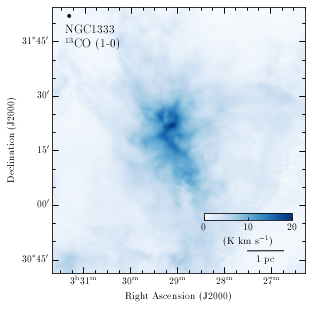

In [4]:
text_color = 'black'

hdu = fits.open(file_list_TdV[0])[0]
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='Blues').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin=0.0, vmax=20.0, cmap=cmap, origin='lower')
ax.invert_xaxis()
ax.invert_yaxis()

plot_setup_ngc1333_wcsaxes(ax, hdu, label_col=text_color, telescope='FCRAO')

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(K km s$^{-1}$)', orientation='horizontal')
# cbar.set_ticks([0, 0.1, 0.2, 0.3])

fig.text(xpos_lab1, ypos_lab1, 'NGC1333', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'$^{13}$CO (1-0)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plt.tight_layout()
fig.savefig('figs/NGC1333_13CO_TdV.pdf', dpi=200)

Set OBSGEO-B to    19.825833 from OBSGEO-[XYZ].
Set OBSGEO-H to       -3.003 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


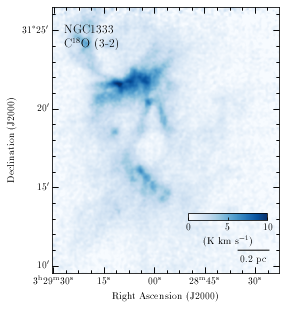

In [5]:
text_color = 'black'

hdu = fits.open(file_list_TdV[1])[0]
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='Blues').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin=0.0, vmax=10, cmap=cmap, origin='lower')

plot_setup_ngc1333_wcsaxes(ax, hdu, label_col=text_color, telescope='JCMT')

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(K km s$^{-1}$)', orientation='horizontal')
cbar.set_ticks([0, 5, 10])

fig.text(xpos_lab1, ypos_lab1, 'NGC1333', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'C$^{18}$O (3-2)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plt.tight_layout()
fig.savefig('figs/NGC1333_C18O_TdV.pdf', dpi=200)

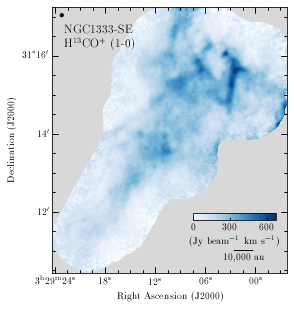

In [6]:
text_color = 'black'

hdu = fits.open(file_list_TdV[2])[0]
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='Blues').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin=0.0, cmap=cmap, origin='lower')

plot_setup_ngc1333_wcsaxes(ax, hdu, label_col=text_color, telescope='NOEMA')

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(Jy beam$^{-1}$ km s$^{-1}$)', orientation='horizontal')
cbar.set_ticks([0, 300, 600])

fig.text(xpos_lab1, ypos_lab1, 'NGC1333-SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'H$^{13}$CO$^+$ (1-0)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plt.tight_layout()
fig.savefig('figs/NGC1333_H13COp_TdV.pdf', dpi=200)

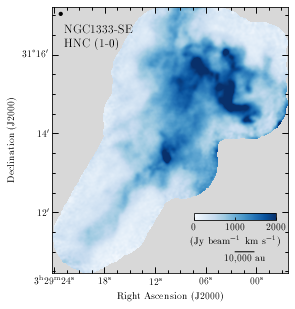

In [7]:
text_color = 'black'

hdu = fits.open(file_list_TdV[3])[0]
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='Blues').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin=0, vmax=2000, cmap=cmap, origin='lower')

plot_setup_ngc1333_wcsaxes(ax, hdu, label_col=text_color, telescope='NOEMA')

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(Jy beam$^{-1}$ km s$^{-1}$)', orientation='horizontal')
# cbar.set_ticks([0, 0.1, 0.2, 0.3])

fig.text(xpos_lab1, ypos_lab1, 'NGC1333-SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'HNC (1-0)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plt.tight_layout()
fig.savefig('figs/NGC1333_HNC_TdV.pdf', dpi=200)

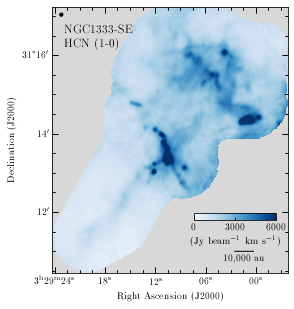

In [8]:
text_color = 'black'

hdu = fits.open(file_list_TdV[4])[0]
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='Blues').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin=0, vmax=6000.0, cmap=cmap, origin='lower')

plot_setup_ngc1333_wcsaxes(ax, hdu, label_col=text_color, telescope='NOEMA')

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(Jy beam$^{-1}$ km s$^{-1}$)', orientation='horizontal')
cbar.set_ticks([0, 3000, 6000])

fig.text(xpos_lab1, ypos_lab1, 'NGC1333-SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'HCN (1-0)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plt.tight_layout()
fig.savefig('figs/NGC1333_HCN_TdV.pdf', dpi=200)

## VCS Analysis
Define function that make all the heave lifting

In [9]:
from turbustat.statistics import VCS
file_h13cop = 'data/NGC1333_H13COp_L17-merged_fix_pad.fits'
file_hcn = 'data/NGC1333_HCN_L21-merged_fix_pad.fits'
file_hnc = 'data/NGC1333_HNC_L23-merged_fix_pad.fits'
file_c18o = 'data/ngc1333_c18o_3-2.fits'
file_13co = 'data/NGC1333_13CO_1-0.fits'

rms_hnc = 0.016 # Jy/beam
rms_hcn = 0.019 # Jy/beam
rms_h13cop = 0.018 # Jy/beam
rms_c18o = 0.21 # K
rms_13co = 0.123 # K

col_pal = ['#e41a1c', '#377eb8', '#4daf4a', 
           '#984ea3', '#ff7f00', '#ffff33']

In [10]:
cube_h13cop = fits.open(file_h13cop)[0]
vcs_h13cop = VCS(cube_h13cop)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     796.7
Date:                Fri, 22 Jul 2022   Prob (F-statistic):           1.22e-63
Time:                        15:01:54   Log-Likelihood:                 130.22
No. Observations:                  92   AIC:                            -252.4
Df Residuals:                      88   BIC:                            -242.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6787      0.019    192.538      0.0

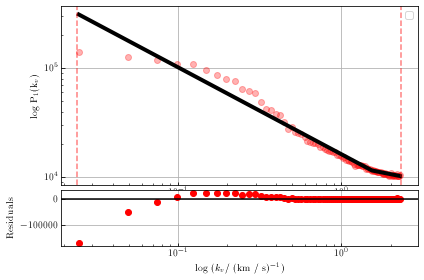

In [11]:
vcs_h13cop.run(verbose=True, xunit=(u.km / u.s)**-1, distance=distance) # high_cut=0.3 / u.pix,

In [12]:
cube_hcn = fits.open(file_hcn)[0]
vcs_hcn = VCS(cube_hcn)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     808.0
Date:                Fri, 22 Jul 2022   Prob (F-statistic):          1.79e-122
Time:                        15:02:14   Log-Likelihood:                 100.05
No. Observations:                 236   AIC:                            -192.1
Df Residuals:                     232   BIC:                            -178.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9007      0.032    121.790      0.0

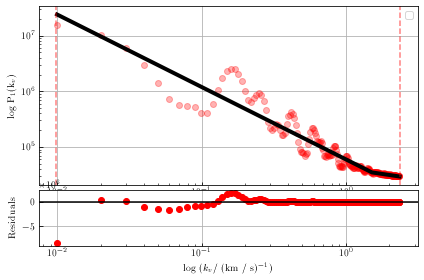

In [13]:
vcs_hcn.run(verbose=True, xunit=(u.km / u.s)**-1, distance=distance) # high_cut=0.3 / u.pix,

In [14]:
cube_hnc = fits.open(file_hnc)[0]
vcs_hnc = VCS(cube_hnc)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     767.4
Date:                Fri, 22 Jul 2022   Prob (F-statistic):           2.65e-76
Time:                        15:02:20   Log-Likelihood:                 56.511
No. Observations:                 120   AIC:                            -105.0
Df Residuals:                     116   BIC:                            -93.87
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3426      0.039     85.730      0.0

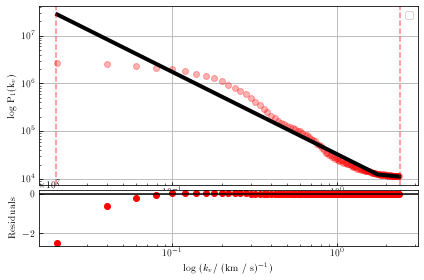

In [15]:
vcs_hnc.run(verbose=True, xunit=(u.km / u.s)**-1, distance=distance)

In [16]:
cube_c18o = fits.open(file_c18o)[0]
vcs_c18o = VCS(cube_c18o)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     3726.
Date:                Fri, 22 Jul 2022   Prob (F-statistic):          2.52e-124
Time:                        15:02:23   Log-Likelihood:                 223.90
No. Observations:                 132   AIC:                            -439.8
Df Residuals:                     128   BIC:                            -428.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6400      0.016    353.149      0.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


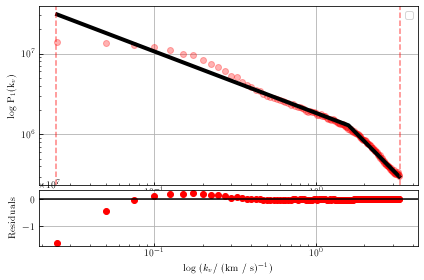

In [17]:
vcs_c18o.run(verbose=True, xunit=(u.km / u.s)**-1, distance=distance)

In [18]:
cube_13co = fits.open(file_13co)[0]
vcs_13co = VCS(cube_13co)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     5227.
Date:                Fri, 22 Jul 2022   Prob (F-statistic):          5.93e-256
Time:                        15:02:27   Log-Likelihood:                 412.84
No. Observations:                 300   AIC:                            -817.7
Df Residuals:                     296   BIC:                            -802.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6722      0.030    122.305      0.0

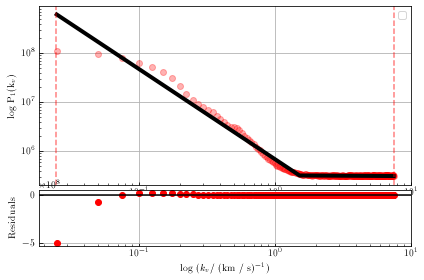

In [19]:
vcs_13co.run(verbose=True, xunit=(u.km / u.s)**-1, distance=distance)

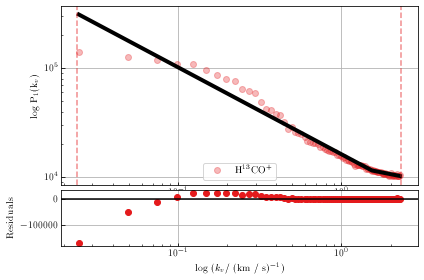

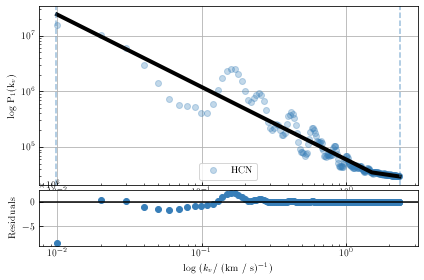

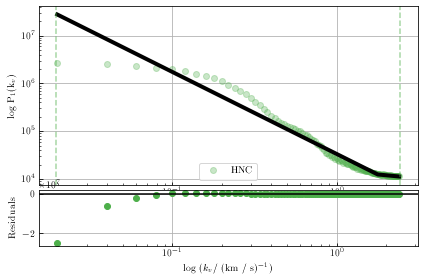

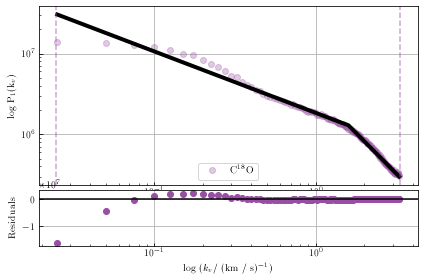

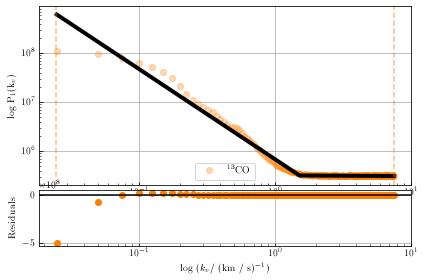

<Figure size 432x288 with 0 Axes>

In [20]:
# import seaborn as sb  
# col_pal = ['red', 'blue', 'orange']#sb.color_palette()  
vcs_h13cop.plot_fit(color=col_pal[0], label=r'H$^{13}$CO$^{+}$', xunit=(u.km / u.s)**-1)
vcs_hcn.plot_fit(color=col_pal[1], label=r'HCN', xunit=(u.km / u.s)**-1)
vcs_hnc.plot_fit(color=col_pal[2], label=r'HNC', xunit=(u.km / u.s)**-1)
vcs_c18o.plot_fit(color=col_pal[3], label=r'C$^{18}$O', xunit=(u.km / u.s)**-1)
vcs_13co.plot_fit(color=col_pal[4], label=r'$^{13}$CO', xunit=(u.km / u.s)**-1)
# plt.legend(frameon=True, loc='lower left')
# plt.xlim([0.1, 2.5])
# plt.ylim([2, 9.5])  
plt.tight_layout()  

Now a plot of all data cubes used in the analysis.

/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.9/site-packages/astropy/units/quantity.py:611: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.9/site-packages/astropy/units/quantity.py:611: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.9/site-packages/astropy/units/quantity.py:611: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.9/site-packages/astropy/units/quantity.py:611: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.9/site-packages/astropy/units/quantity.py:

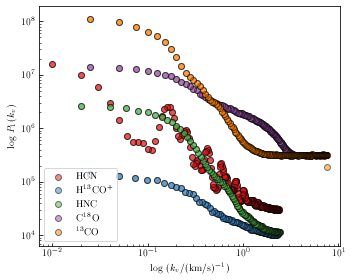

In [21]:
fig, ax = plt.subplots(figsize = (5, 4))
# conv_NH3
ax.scatter(vcs_hcn._spectral_freq_unit_conversion(vcs_hcn.freqs, (u.km / u.s)**-1), 
           vcs_hcn.ps1D, 
           color=col_pal[0], label=r'HCN', alpha=0.5, edgecolors="k")

ax.scatter(vcs_h13cop._spectral_freq_unit_conversion(vcs_h13cop.freqs, (u.km / u.s)**-1),
           vcs_h13cop.ps1D, 
           color=col_pal[1], label=r'H$^{13}$CO$^{+}$', alpha=0.5, edgecolors="k")

ax.scatter(vcs_hnc._spectral_freq_unit_conversion(vcs_hnc.freqs, (u.km / u.s)**-1),
           vcs_hnc.ps1D, 
           color=col_pal[2], label=r'HNC', alpha=0.5, edgecolors="k")

ax.scatter(vcs_c18o._spectral_freq_unit_conversion(vcs_c18o.freqs, (u.km / u.s)**-1),
           vcs_c18o.ps1D, 
           color=col_pal[3], label=r'C$^{18}$O', alpha=0.5, edgecolors="k")

ax.scatter(vcs_13co._spectral_freq_unit_conversion(vcs_13co.freqs, (u.km / u.s)**-1),
           vcs_13co.ps1D, 
           color=col_pal[4], label=r'$^{13}$CO', alpha=0.5, edgecolors="k")

plt.legend(frameon=True, loc='lower left')
ax.set_xlabel(r'log ($k_v$/(km/s)$^{-1}$)')
ax.set_ylabel('log $P_1(k_v)$')
ax.set_xscale("log")
ax.set_yscale("log")

plt.tight_layout()
fig.savefig('figs/NGC1333_VCS_lines.pdf')

## Now try PCA
Maybe this will work better

In [22]:
from turbustat.statistics import PCA

In [23]:
pca_hcn = PCA(cube_hcn, distance=distance)

Proportion of Variance kept: 0.6750060266024159
Index: -3.01 (-4.06, -1.96)
Gamma: -4.77 (-5.84, -3.32)
Sonic length: 1.398e+01 (1.756e+01, 1.040e+01) pix at 10.0 K


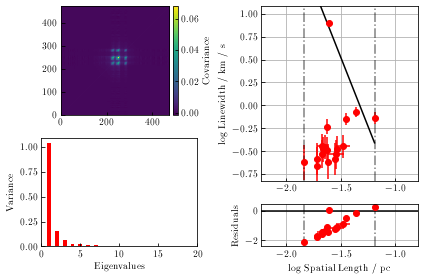

In [24]:
pca_hcn.run(verbose=True, min_eigval=3.5*rms_hcn**2, spatial_output_unit=u.pc,
        spectral_output_unit=u.km / u.s, brunt_beamcorrect=True)

In [25]:
pca_hnc = PCA(cube_hnc, distance=distance)

Proportion of Variance kept: 0.7937563041501629
Index: 0.08 (-0.05, 0.20)
Gamma: -0.08 (-0.45, 0.34)
Sonic length: 1.924e+08 (8.150e+09, -7.765e+09) pix at 10.0 K


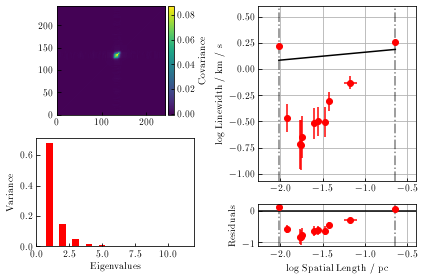

In [26]:
pca_hnc.run(verbose=True, min_eigval=3*rms_hnc**2, spatial_output_unit=u.pc, # n_eigs=10, 
        spectral_output_unit=u.km / u.s, brunt_beamcorrect=True)

In [27]:
pca_h13cop = PCA(cube_h13cop, distance=distance)

Proportion of Variance kept: 0.19155211099225275
Index: 0.62 (0.59, 0.64)
Gamma: 0.75 (0.41, 1.09)
Sonic length: 9.197e+00 (4.430e+00, 1.396e+01) pix at 10.0 K


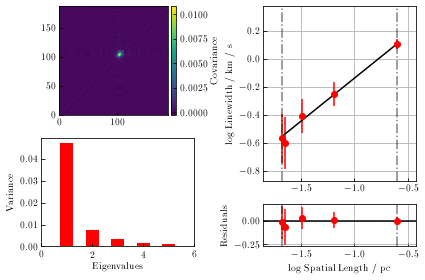

In [28]:
pca_h13cop.run(verbose=True, min_eigval=3*rms_h13cop**2, spatial_output_unit=u.pc,  #n_eigs=10,
        spectral_output_unit=u.km / u.s, brunt_beamcorrect=True)#,
#               beam_fwhm=cube_h13cop.header['BMAJ']*u.deg)

In [29]:
pca_c18o = PCA(cube_c18o, distance=distance)

Proportion of Variance kept: 0.17146024804141086
Index: 0.43 (0.38, 0.49)
Gamma: 0.47 (0.12, 0.84)
Sonic length: 5.501e+00 (2.256e+00, 8.746e+00) pix at 10.0 K


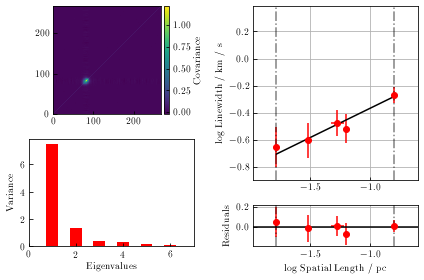

In [30]:
pca_c18o.run(verbose=True, min_eigval=3*rms_c18o**2, spatial_output_unit=u.pc,  #n_eigs=10,
        spectral_output_unit=u.km / u.s, brunt_beamcorrect=True, beam_fwhm=14*u.arcsec)

In [31]:
pca_13co = PCA(cube_13co, distance=distance)

Proportion of Variance kept: 0.6550338592290976
Index: 0.50 (0.43, 0.58)
Gamma: 0.58 (0.18, 1.00)
Sonic length: 2.069e+00 (1.613e+00, 2.526e+00) pix at 10.0 K


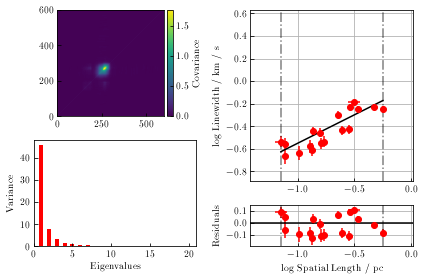

In [32]:
pca_13co.run(verbose=True, min_eigval=3*rms_13co**2, spatial_output_unit=u.pc,  #n_eigs=10,
        spectral_output_unit=u.km / u.s, brunt_beamcorrect=True)#, beam_fwhm=14*u.arcsec)

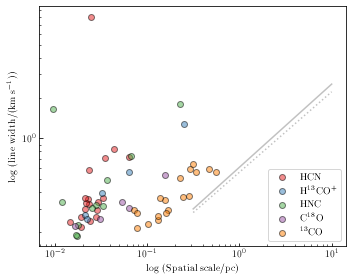

In [33]:
fig, ax = plt.subplots(figsize = (5, 4))

x_sample = np.logspace(-0.5, 1, num=10)
# conv_NH3
ax.scatter(pca_hcn.spatial_width(u.pc), 
           pca_hcn.spectral_width(u.km / u.s), 
           color=col_pal[0], label=r'HCN', alpha=0.5, edgecolors="k")

ax.scatter(pca_h13cop.spatial_width(u.pc),
           pca_h13cop.spectral_width(u.km / u.s),
           color=col_pal[1], label=r'H$^{13}$CO$^{+}$', alpha=0.5, edgecolors="k")

ax.scatter(pca_hnc.spatial_width(u.pc),
           pca_hnc.spectral_width(u.km / u.s), 
           color=col_pal[2], label=r'HNC', alpha=0.5, edgecolors="k")

ax.scatter(pca_c18o.spatial_width(u.pc),
           pca_c18o.spectral_width(u.km / u.s), 
           color=col_pal[3], label=r'C$^{18}$O', alpha=0.5, edgecolors="k")

ax.scatter(pca_13co.spatial_width(u.pc),
           pca_13co.spectral_width(u.km / u.s), 
           color=col_pal[4], label=r'$^{13}$CO', alpha=0.5, edgecolors="k")


# ax.set_ylim([0.1, 1e5])
# ax.set_xlim([3, 200])
# PCA values taken from Figure 11 in Roman-Duval et al. (2011)
# https://ui.adsabs.harvard.edu/abs/2011ApJ...740..120R/abstract
alpha_PCA = 0.62
c_PCA = 0.61
alpha_PCA_med = 0.60
c_PCA_med = 0.56
ax.plot(x_sample, c_PCA * x_sample**alpha_PCA, color='0.4', alpha=0.4)
ax.plot(x_sample, c_PCA_med * x_sample**alpha_PCA_med, color='0.4', alpha=0.4, ls=':')

plt.legend(frameon=True, loc='lower right')
ax.set_xlabel(r'log (Spatial scale/pc)')
ax.set_ylabel(r'log (line width/(km s$^{-1}$))')
ax.set_xscale("log")
ax.set_yscale("log")

plt.tight_layout()
fig.savefig('figs/NGC1333_PCA_lines.pdf')

In [34]:
import pickle

In [35]:
with open('data/NGC1333_PCA_HCN.pickle', 'wb') as handle:
    pickle.dump(pca_hcn, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [36]:
with open('data/NGC1333_PCA_HNC.pickle', 'wb') as handle:
    pickle.dump(pca_hnc, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [37]:
with open('data/NGC1333_PCA_H13COp.pickle', 'wb') as handle:
    pickle.dump(pca_h13cop, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [38]:
with open('data/NGC1333_PCA_C18O.pickle', 'wb') as handle:
    pickle.dump(pca_c18o, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [39]:
with open('data/NGC1333_PCA_13CO.pickle', 'wb') as handle:
    pickle.dump(pca_13co, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# with open('data/NGC1333_PCA_13CO.pickle', 'rb') as handle:
#     pca_13co = pickle.load(handle)